In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LSTM, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import VotingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
def Plot_g(model,y_test,pred_test):
  dtX=dt.predict(y_test)
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  categoryNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ticks = np.arange(len(categoryNames))
  plt.xticks(ticks, categoryNames, rotation=45)
  plt.yticks(ticks, categoryNames)
  s = [['TN','FP'], ['FN', 'TP']]

In [7]:
def Plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  categoryNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ticks = np.arange(len(categoryNames))
  plt.xticks(ticks, categoryNames, rotation=45)
  plt.yticks(ticks, categoryNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  plt.show()
  print(classification_report(y_test,pred_test))

In [8]:
def Plot_roc(y_test,y_pred_logistic):
    logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_logistic)
    auc_logistic = auc(logistic_fpr, logistic_tpr)

    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)

    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')

    plt.legend()

    plt.show()

In [9]:
def plot_learning_curve(history, epoch):
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc= 'upper left')
    plt.show()
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc= 'upper left')
    plt.show()

In [10]:
dataset = pd.read_csv("creditcard.csv")

In [11]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
dataset.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

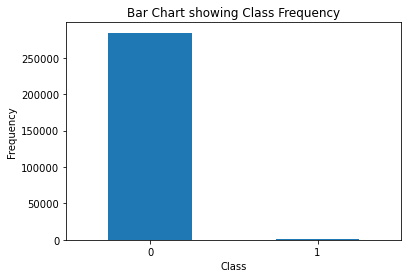

In [13]:
cl_no = pd.value_counts(dataset['Class'])
cl_no.plot(kind='bar', rot = 0)
plt.title("Bar Chart showing Class Frequency")
plt.xlabel("Class")
plt.ylabel("Frequency")

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


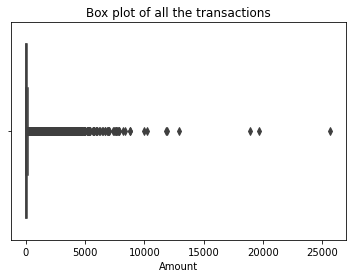

In [14]:
plt.title("Box plot of all the transactions")
sns.boxplot(x=dataset.Amount)
print(dataset.Amount.describe())
plt.show()

In [15]:
fraud = dataset[dataset['Class']==1]
authentic = dataset[dataset['Class']==0]

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


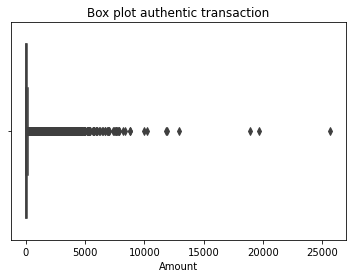

In [16]:
plt.title("Box plot authentic transaction")
sns.boxplot(x=authentic.Amount)
print(authentic.Amount.describe())
plt.show()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


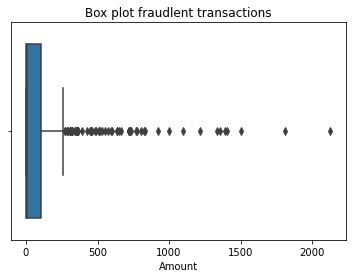

In [17]:
plt.title("Box plot fraudlent transactions")
sns.boxplot(x=fraud.Amount)
print(fraud.Amount.describe())
plt.show()

Text(0.5, 1.0, 'Amount of fraudulent transactions')

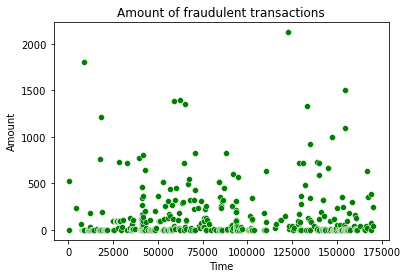

In [66]:
sns.scatterplot(data=dataset[dataset['Class']==1], x='Time', y='Amount',color='green',)
plt.title('Amount of fraudulent transactions')


<AxesSubplot:xlabel='Time', ylabel='Amount'>

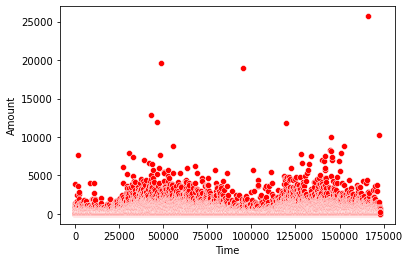

In [55]:
sns.scatterplot(data=dataset[dataset['Class']==0], x='Time', y='Amount',color='red',)
plt.title('Amount of Non-transactions')

<Figure size 432x288 with 0 Axes>

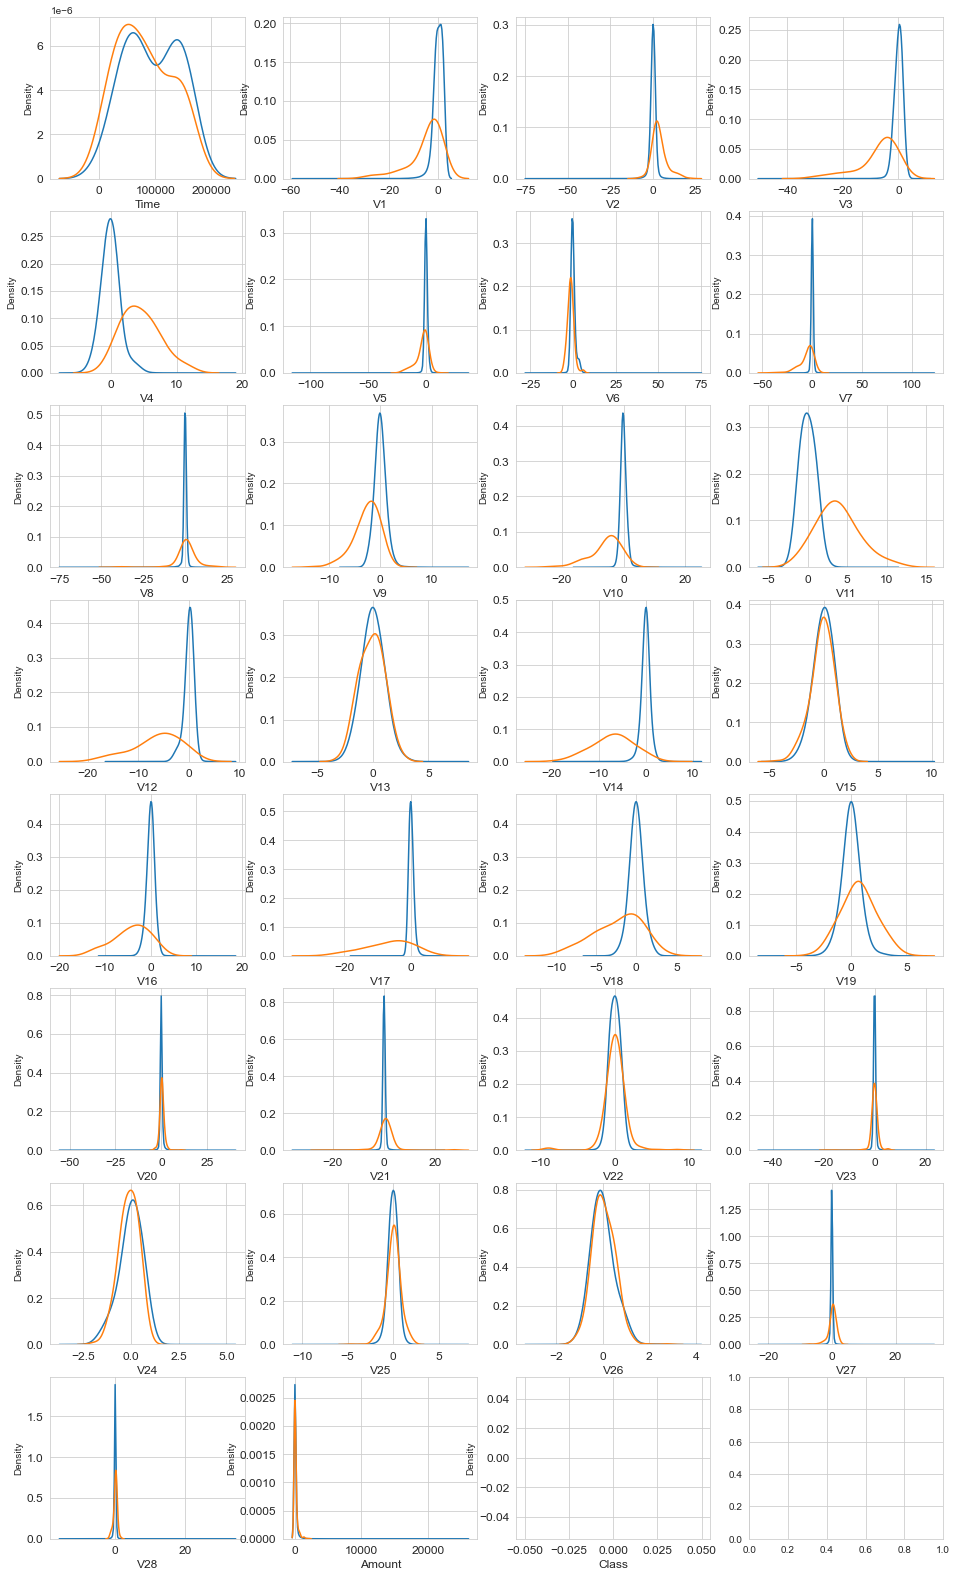

In [69]:
var = dataset.columns.values

i = 0
t0 = dataset.loc[dataset['Class'] == 0]
t1 = dataset.loc[dataset['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();


In [18]:
train,test=train_test_split(dataset,test_size =0.2,random_state = 0,stratify=dataset['Class'])
train,val=train_test_split(train,test_size =0.2,random_state = 0,stratify=train['Class'])
X = train.drop('Class', axis =1 )
y= train['Class']
X1 = val.drop('Class', axis =1 )
y1= val['Class']
X_test = test.drop('Class', axis =1 )
y_test= test['Class']

In [19]:
smote = SMOTE(sampling_strategy = 'minority')
X_train,y_train=smote.fit_resample(X,y)

smote = SMOTE(sampling_strategy = 'minority')
X_val,y_val=smote.fit_resample(X1,y1)

smote = SMOTE(sampling_strategy = 'minority')
X_test,y_test=smote.fit_resample(X_test,y_test)

In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.fit_transform(X_val)
X_test = sc.transform(X_test)

In [21]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [34]:
knn=KNeighborsClassifier(n_neighbors = 5, n_jobs = 16)
knn.fit(X_train, y_train)
pred_knn=knn.predict(X_test)

In [35]:
LGR=LogisticRegression(solver='lbfgs', max_iter=1000,)
LGR.fit(X_train,y_train)
pred_LGR=LGR.predict(X_test)

In [38]:
dt=DecisionTreeClassifier(criterion ='gini', random_state=42)
dt.fit(X_train, y_train)
dtX=dt.predict(X_test)
print(dtX)

[0 0 0 ... 1 1 1]


In [36]:
mlp = MLPClassifier(hidden_layer_sizes=(3,2), activation = 'relu')
mlp.fit(X_train,y_train)
pred= mlp.predict(X_test)

In [40]:
vote = VotingClassifier(estimators=[("DT",dt),("LGR",LGR),("knn",knn)],voting='hard',weights = None,n_jobs= None,flatten_transform=True,)
vote.fit(X_train, y_train)
v=vote.predict(X_test)

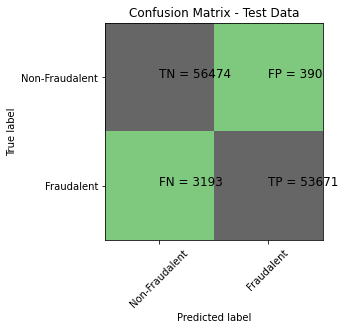

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     56864
           1       0.99      0.94      0.97     56864

    accuracy                           0.97    113728
   macro avg       0.97      0.97      0.97    113728
weighted avg       0.97      0.97      0.97    113728



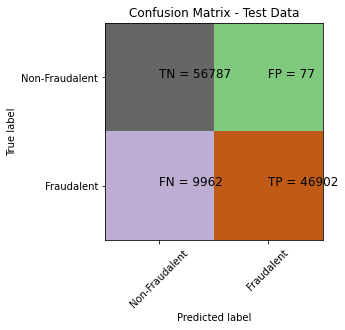

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     56864
           1       1.00      0.82      0.90     56864

    accuracy                           0.91    113728
   macro avg       0.92      0.91      0.91    113728
weighted avg       0.92      0.91      0.91    113728



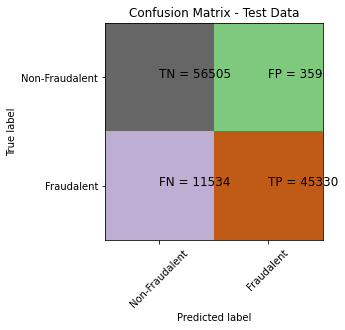

              precision    recall  f1-score   support

           0       0.83      0.99      0.90     56864
           1       0.99      0.80      0.88     56864

    accuracy                           0.90    113728
   macro avg       0.91      0.90      0.89    113728
weighted avg       0.91      0.90      0.89    113728



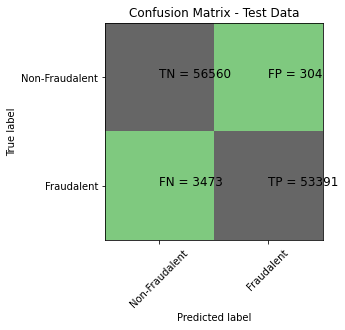

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     56864
           1       0.99      0.94      0.97     56864

    accuracy                           0.97    113728
   macro avg       0.97      0.97      0.97    113728
weighted avg       0.97      0.97      0.97    113728



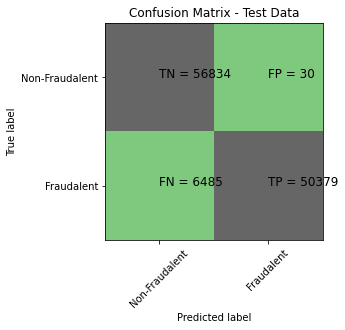

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     56864
           1       1.00      0.89      0.94     56864

    accuracy                           0.94    113728
   macro avg       0.95      0.94      0.94    113728
weighted avg       0.95      0.94      0.94    113728



In [42]:
Plot_confusion_matrix(y_test,pred_LGR)
Plot_confusion_matrix(y_test,pred_knn)
Plot_confusion_matrix(y_test,dtX)
Plot_confusion_matrix(y_test,pred)
Plot_confusion_matrix(y_test,v)

In [43]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [44]:
epochs = 20
cnnModel = Sequential()
cnnModel.add(Conv1D(32, 2, activation = "relu",input_shape = X_train[0].shape))
cnnModel.add(BatchNormalization())
cnnModel.add(Dropout(0.2))

cnnModel.add(Conv1D(64,2, activation = 'relu'))
cnnModel.add(BatchNormalization())
cnnModel.add(Dropout(0.5))

cnnModel.add(Flatten())
cnnModel.add(Dense(1,activation = 'sigmoid'))

In [45]:
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 32)            96        
                                                                 
 batch_normalization (BatchN  (None, 29, 32)           128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 29, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 64)            4160      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 28, 64)            0

In [61]:
callbacks=[EarlyStopping(monitor='val_accuracy', patience=3)]
cnnModel.compile(optimizer = Adam(learning_rate = 0.001), loss ="binary_crossentropy", metrics=['accuracy'])

In [62]:
cnnOut = cnnModel.fit(X_train,y_train, epochs=epochs, verbose=1 ,callbacks=callbacks,validation_data = (X_val,y_val))

Epoch 1/20
11373/11373 [==============================] - 54s 5ms/step - loss: 0.0423 - accuracy: 0.9849 - val_loss: 0.0399 - val_accuracy: 0.9921
Epoch 2/20
11373/11373 [==============================] - 53s 5ms/step - loss: 0.0386 - accuracy: 0.9863 - val_loss: 0.0398 - val_accuracy: 0.9920
Epoch 3/20
11373/11373 [==============================] - 56s 5ms/step - loss: 0.0363 - accuracy: 0.9870 - val_loss: 0.0397 - val_accuracy: 0.9927
Epoch 4/20
11373/11373 [==============================] - 73s 6ms/step - loss: 0.0344 - accuracy: 0.9878 - val_loss: 0.0372 - val_accuracy: 0.9904
Epoch 5/20
11373/11373 [==============================] - 62s 5ms/step - loss: 0.0334 - accuracy: 0.9883 - val_loss: 0.0418 - val_accuracy: 0.9917
Epoch 6/20
11373/11373 [==============================] - 67s 6ms/step - loss: 0.0331 - accuracy: 0.9883 - val_loss: 0.0356 - val_accuracy: 0.9929
Epoch 7/20
11373/11373 [==============================] - 71s 6ms/step - loss: 0.0317 - accuracy: 0.9888 - val_loss: 0

In [51]:
annModel = Sequential([Dense(units=16,input_dim=29,activation = 'relu',input_shape = X_train[0].shape),
                    Dense(units=32,activation='relu'),
                    Dropout(0.2),Dense(units=20,activation='relu'),
                    Dense(units=64,activation='relu'),
                    Flatten(),
                    Dense(1,activation='sigmoid')])

In [52]:
callbacks=[EarlyStopping(monitor='val_accuracy', patience=3)]
annModel.compile(optimizer = Adam(learning_rate = 0.0001), loss ="binary_crossentropy", metrics=['accuracy'])
annModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 30, 16)            32        
                                                                 
 dense_2 (Dense)             (None, 30, 32)            544       
                                                                 
 dropout_2 (Dropout)         (None, 30, 32)            0         
                                                                 
 dense_3 (Dense)             (None, 30, 20)            660       
                                                                 
 dense_4 (Dense)             (None, 30, 64)            1344      
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [53]:
annOut = annModel.fit(X_train,y_train, epochs=epochs, validation_data = (X_val,y_val), verbose=1, callbacks=callbacks)

Epoch 1/20
11373/11373 [==============================] - 28s 2ms/step - loss: 0.1006 - accuracy: 0.9636 - val_loss: 0.0371 - val_accuracy: 0.9901
Epoch 2/20
11373/11373 [==============================] - 33s 3ms/step - loss: 0.0591 - accuracy: 0.9793 - val_loss: 0.0342 - val_accuracy: 0.9920
Epoch 3/20
11373/11373 [==============================] - 41s 4ms/step - loss: 0.0525 - accuracy: 0.9813 - val_loss: 0.0325 - val_accuracy: 0.9910
Epoch 4/20
11373/11373 [==============================] - 39s 3ms/step - loss: 0.0471 - accuracy: 0.9832 - val_loss: 0.0305 - val_accuracy: 0.9923
Epoch 5/20
11373/11373 [==============================] - 40s 4ms/step - loss: 0.0436 - accuracy: 0.9841 - val_loss: 0.0309 - val_accuracy: 0.9913
Epoch 6/20
11373/11373 [==============================] - 36s 3ms/step - loss: 0.0408 - accuracy: 0.9852 - val_loss: 0.0291 - val_accuracy: 0.9919
Epoch 7/20
11373/11373 [==============================] - 33s 3ms/step - loss: 0.0387 - accuracy: 0.9859 - val_loss: 0

In [54]:
rnnModel = Sequential()
rnnModel.add(LSTM(20, input_shape=X_train[0].shape, kernel_initializer='lecun_uniform', activation='relu', kernel_regularizer=regularizers.l1(0.1), recurrent_regularizer=regularizers.l1(0.01), bias_regularizer=None, activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
rnnModel.add(LSTM(12, activation='relu', return_sequences=True))
rnnModel.add(LSTM(8, activation='relu'))
rnnModel.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))

In [55]:
callbacks=[EarlyStopping(monitor='val_accuracy', patience=3)]
rnnModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnnModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 20)            1760      
                                                                 
 lstm_1 (LSTM)               (None, 30, 12)            1584      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 672       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,025
Trainable params: 4,025
Non-trainable params: 0
_________________________________________________________________


In [56]:
rnnOut=rnnModel.fit(X_train, y_train, epochs=epochs, batch_size=10000,validation_data = (X_val,y_val),callbacks=callbacks)

Epoch 1/20
37/37 [==============================] - 30s 727ms/step - loss: 9.0194 - accuracy: 0.7726 - val_loss: 8.3082 - val_accuracy: 0.9190
Epoch 2/20
37/37 [==============================] - 30s 801ms/step - loss: 8.0463 - accuracy: 0.8761 - val_loss: 7.5773 - val_accuracy: 0.9461
Epoch 3/20
37/37 [==============================] - 30s 808ms/step - loss: 7.4721 - accuracy: 0.8807 - val_loss: 7.1071 - val_accuracy: 0.9370
Epoch 4/20
37/37 [==============================] - 30s 824ms/step - loss: 6.9902 - accuracy: 0.8940 - val_loss: 6.6616 - val_accuracy: 0.9484
Epoch 5/20
37/37 [==============================] - 37s 1s/step - loss: 6.5854 - accuracy: 0.8999 - val_loss: 6.2924 - val_accuracy: 0.9442
Epoch 6/20
37/37 [==============================] - 41s 1s/step - loss: 6.2280 - accuracy: 0.9066 - val_loss: 5.9301 - val_accuracy: 0.9719
Epoch 7/20
37/37 [==============================] - 44s 1s/step - loss: 5.9002 - accuracy: 0.9110 - val_loss: 5.6199 - val_accuracy: 0.9728
Epoch 8/

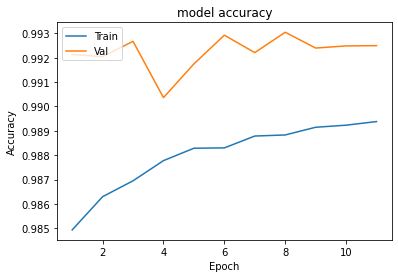

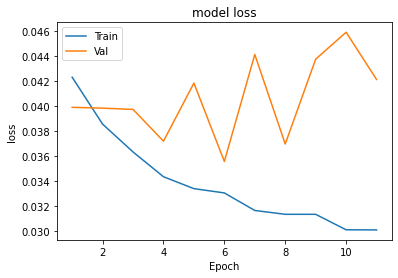

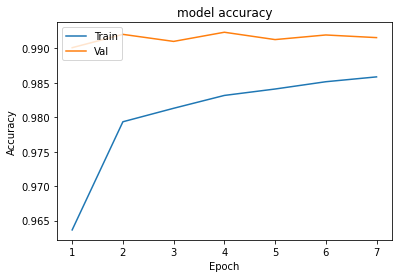

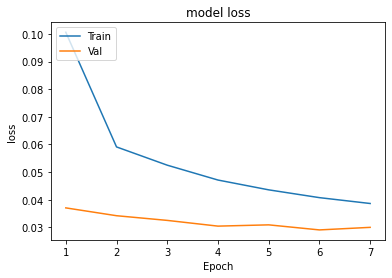

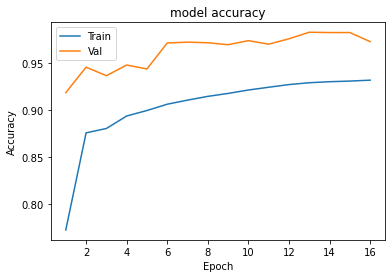

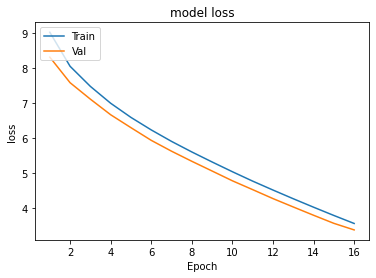

In [63]:
plot_learning_curve(cnnOut, 11)
plot_learning_curve(annOut, 7)
plot_learning_curve(rnnOut, 16)

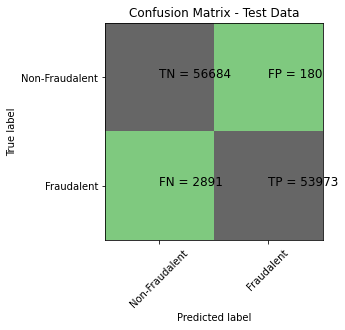

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     56864
           1       1.00      0.95      0.97     56864

    accuracy                           0.97    113728
   macro avg       0.97      0.97      0.97    113728
weighted avg       0.97      0.97      0.97    113728



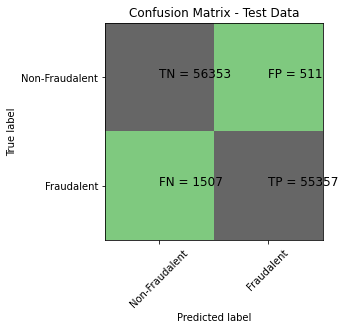

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56864
           1       0.99      0.97      0.98     56864

    accuracy                           0.98    113728
   macro avg       0.98      0.98      0.98    113728
weighted avg       0.98      0.98      0.98    113728



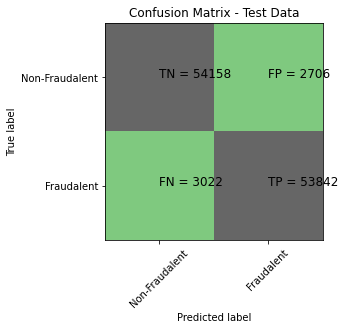

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     56864
           1       0.95      0.95      0.95     56864

    accuracy                           0.95    113728
   macro avg       0.95      0.95      0.95    113728
weighted avg       0.95      0.95      0.95    113728



In [58]:
d1=(cnnModel.predict(X_test)>=0.5).astype(int)
Plot_confusion_matrix(y_test, d1)
d2=(annModel.predict(X_test)>=0.5).astype(int)
Plot_confusion_matrix(y_test, d2)
d3=(rnnModel.predict(X_test)>=0.5).astype(int)
Plot_confusion_matrix(y_test, d3)